# Frequency-Domain Audio Features: BER, Spectral Centroid, and Spectral Bandwidth



## Introduction



While **time-domain features** (like Amplitude Envelope and Zero Crossing Rate) extract information directly from the raw audio waveform, **frequency-domain features** analyze the spectral characteristics of sound. These features are crucial for understanding the **timbre** and **tonal quality** of audio signals.



### Time-Domain vs Frequency-Domain Features



| Domain | Examples | What They Capture |
|--------|----------|-------------------|
| **Time-Domain** | Amplitude Envelope, ZCR, RMS Energy | Loudness, temporal dynamics, noisiness |
| **Frequency-Domain** | BER, Spectral Centroid, Bandwidth | Brightness, spectral shape, energy distribution |



### Three Key Frequency-Domain Features



In this notebook, we'll explore three fundamental frequency-domain features:



1. **Band Energy Ratio (BER)**: Measures energy distribution across frequency bands
2. **Spectral Centroid**: Indicates the "brightness" or "center of mass" of the spectrum
3. **Spectral Bandwidth (Spread)**: Describes how spread out the frequencies are around the centroid



These features are essential for:
- Music Genre Classification
- Speech Analysis (voiced vs unvoiced)
- Instrument Recognition
- Emotion Detection
- Audio Event Classification

In [19]:
# Import required libraries

import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import io
import urllib.request
import pandas as pd

# Set plot style
plt.style.use('default')
%matplotlib inline

## 1. Loading Audio Files

In [20]:
def load_audio_from_url(url):
    """Load audio directly from URL without saving to disk"""
    try:
        print(f"Streaming audio from URL...")
        # Download to memory
        with urllib.request.urlopen(url) as response:
            audio_data = response.read()
        
        # Create a file-like object in memory
        audio_file = io.BytesIO(audio_data)
        
        # Read WAV file from memory
        sample_rate, audio_array = wavfile.read(audio_file)
        
        # Convert to mono if stereo
        if len(audio_array.shape) > 1:
            audio_array = audio_array.mean(axis=1)
        
        # Normalize
        audio_array = audio_array.astype(float)
        if np.max(np.abs(audio_array)) > 0:
            audio_array = audio_array / np.max(np.abs(audio_array))
        
        print(f"✓ Loaded audio: {len(audio_array)} samples at {sample_rate} Hz")
        return audio_array, sample_rate
        
    except Exception as e:
        print(f"✗ Failed to load audio: {e}")
        return None, None

# Try to load audio from online source
print("="*70)
print("AUDIO LOADING (NO FILES SAVED)")
print("="*70)

# Try multiple sources
audio_urls = [
    'https://www.kozco.com/tech/organfinale.wav',
    'https://www.kozco.com/tech/piano2.wav',
    'https://www.kozco.com/tech/audacity/1.wav',
    'https://www.kozco.com/tech/audacity/1a.wav',
]

# Collect multiple audio files
audio_files = []

for url in audio_urls:
    audio_data, sample_rate = load_audio_from_url(url)
    if audio_data is not None:
        audio_files.append({
            'data': audio_data,
            'sample_rate': sample_rate,
            'url': url,
            'name': url.split('/')[-1]
        })
        print(f"✓ Added to collection: {url.split('/')[-1]}")

print(f"\n{'='*70}")
print(f"Successfully loaded {len(audio_files)} audio file(s)")
print(f"{'='*70}")

# Assign audio files to variables
scale, sr = audio_files[0]['data'], audio_files[0]['sample_rate']
piano, _ = audio_files[1]['data'], audio_files[1]['sample_rate']
voice1, _ = audio_files[2]['data'], audio_files[2]['sample_rate']
voice2, _ = audio_files[3]['data'], audio_files[3]['sample_rate']

AUDIO LOADING (NO FILES SAVED)
Streaming audio from URL...


/tmp/ipython-input-365913511.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_array = wavfile.read(audio_file)


✓ Loaded audio: 573378 samples at 44100 Hz
✓ Added to collection: organfinale.wav
Streaming audio from URL...
✓ Loaded audio: 302712 samples at 48000 Hz
✓ Added to collection: piano2.wav
Streaming audio from URL...
✓ Loaded audio: 1332529 samples at 44100 Hz
✓ Added to collection: 1.wav
Streaming audio from URL...
✓ Loaded audio: 1332578 samples at 44100 Hz
✓ Added to collection: 1a.wav

Successfully loaded 4 audio file(s)


## 2. Band Energy Ratio (BER)



### Theory



**Band Energy Ratio (BER)** measures how much energy is contained within a specific frequency band relative to the total energy of the signal. It captures the "heaviness" or energy distribution of sound across different frequency ranges.



### Mathematical Definition



$$\text{BER} = \frac{\sum_{f=f_{\text{low}}}^{f_{\text{split}}} |X(f)|^2}{\sum_{f=f_{\text{low}}}^{f_{\text{high}}} |X(f)|^2}$$



Where:
- $X(f)$ = magnitude of frequency component at frequency $f$
- $f_{\text{split}}$ = frequency that divides the spectrum (e.g., 2000 Hz)
- Numerator = energy in the lower frequency band
- Denominator = total energy across all frequencies



### Interpretation



- **High BER** (close to 1): Most energy is in the lower frequencies (e.g., bass-heavy music like Reggae)
- **Low BER** (close to 0): Most energy is in the higher frequencies (e.g., cymbals, high-pitched sounds)
- **Medium BER** (~0.5): Balanced energy distribution



### Applications



1. **Music Genre Classification**: Distinguishing bass-heavy genres from treble-heavy ones
2. **Speech Analysis**: Differentiating voiced (low-frequency) vs unvoiced (high-frequency) segments
3. **Instrument Recognition**: Identifying bass instruments vs high-pitched instruments

## 3. Computing Band Energy Ratio from Scratch

In [21]:
# Parameters
FRAME_SIZE = 2048
HOP_SIZE = 512
SPLIT_FREQUENCY = 2000  # Hz

# Compute STFT for scale audio
S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y_scale = np.abs(S_scale) ** 2  # Power spectrogram

print(f"STFT Shape: {S_scale.shape}")
print(f"Power Spectrogram Shape: {Y_scale.shape}")
print(f"Frequency bins: {Y_scale.shape[0]}")
print(f"Time frames: {Y_scale.shape[1]}")

STFT Shape: (1025, 1120)
Power Spectrogram Shape: (1025, 1120)
Frequency bins: 1025
Time frames: 1120


In [22]:
def calculate_split_frequency_bin(split_frequency_hz, sr, n_fft):
    """
    Calculate the FFT bin corresponding to a given frequency.
    
    Parameters:
    - split_frequency_hz: Frequency in Hz to split the spectrum
    - sr: Sample rate
    - n_fft: FFT size
    
    Returns:
    - Frequency bin index
    """
    frequency_range = sr / 2  # Nyquist frequency
    frequency_delta_per_bin = frequency_range / (n_fft / 2)
    split_frequency_bin = int(np.floor(split_frequency_hz / frequency_delta_per_bin))
    return split_frequency_bin

# Calculate split frequency bin
split_freq_bin = calculate_split_frequency_bin(SPLIT_FREQUENCY, sr, FRAME_SIZE)
print(f"Split frequency: {SPLIT_FREQUENCY} Hz")
print(f"Split frequency bin: {split_freq_bin}")
print(f"Actual frequency at bin {split_freq_bin}: {split_freq_bin * (sr/2) / (FRAME_SIZE/2):.2f} Hz")

Split frequency: 2000 Hz
Split frequency bin: 92
Actual frequency at bin 92: 1981.05 Hz


In [23]:
def band_energy_ratio(spectrogram, split_frequency_bin):
    """
    Calculate Band Energy Ratio for each frame.
    
    Parameters:
    - spectrogram: Power spectrogram (frequency bins x time frames)
    - split_frequency_bin: Bin index to split low/high frequencies
    
    Returns:
    - BER values for each time frame
    """
    # Energy in lower band (0 to split_frequency_bin)
    power_spec_low = spectrogram[:split_frequency_bin, :]
    power_spec_low = np.sum(power_spec_low, axis=0)
    
    # Total energy (all frequencies)
    power_spec_total = np.sum(spectrogram, axis=0)
    
    # Calculate BER (avoid division by zero)
    ber = power_spec_low / (power_spec_total + 1e-10)
    
    return ber

# Calculate BER for scale audio
ber_scale = band_energy_ratio(Y_scale, split_freq_bin)
print(f"BER shape: {ber_scale.shape}")
print(f"BER range: [{ber_scale.min():.3f}, {ber_scale.max():.3f}]")
print(f"Mean BER: {ber_scale.mean():.3f}")

BER shape: (1120,)
BER range: [0.308, 0.999]
Mean BER: 0.969


## 4. Visualizing Band Energy Ratio

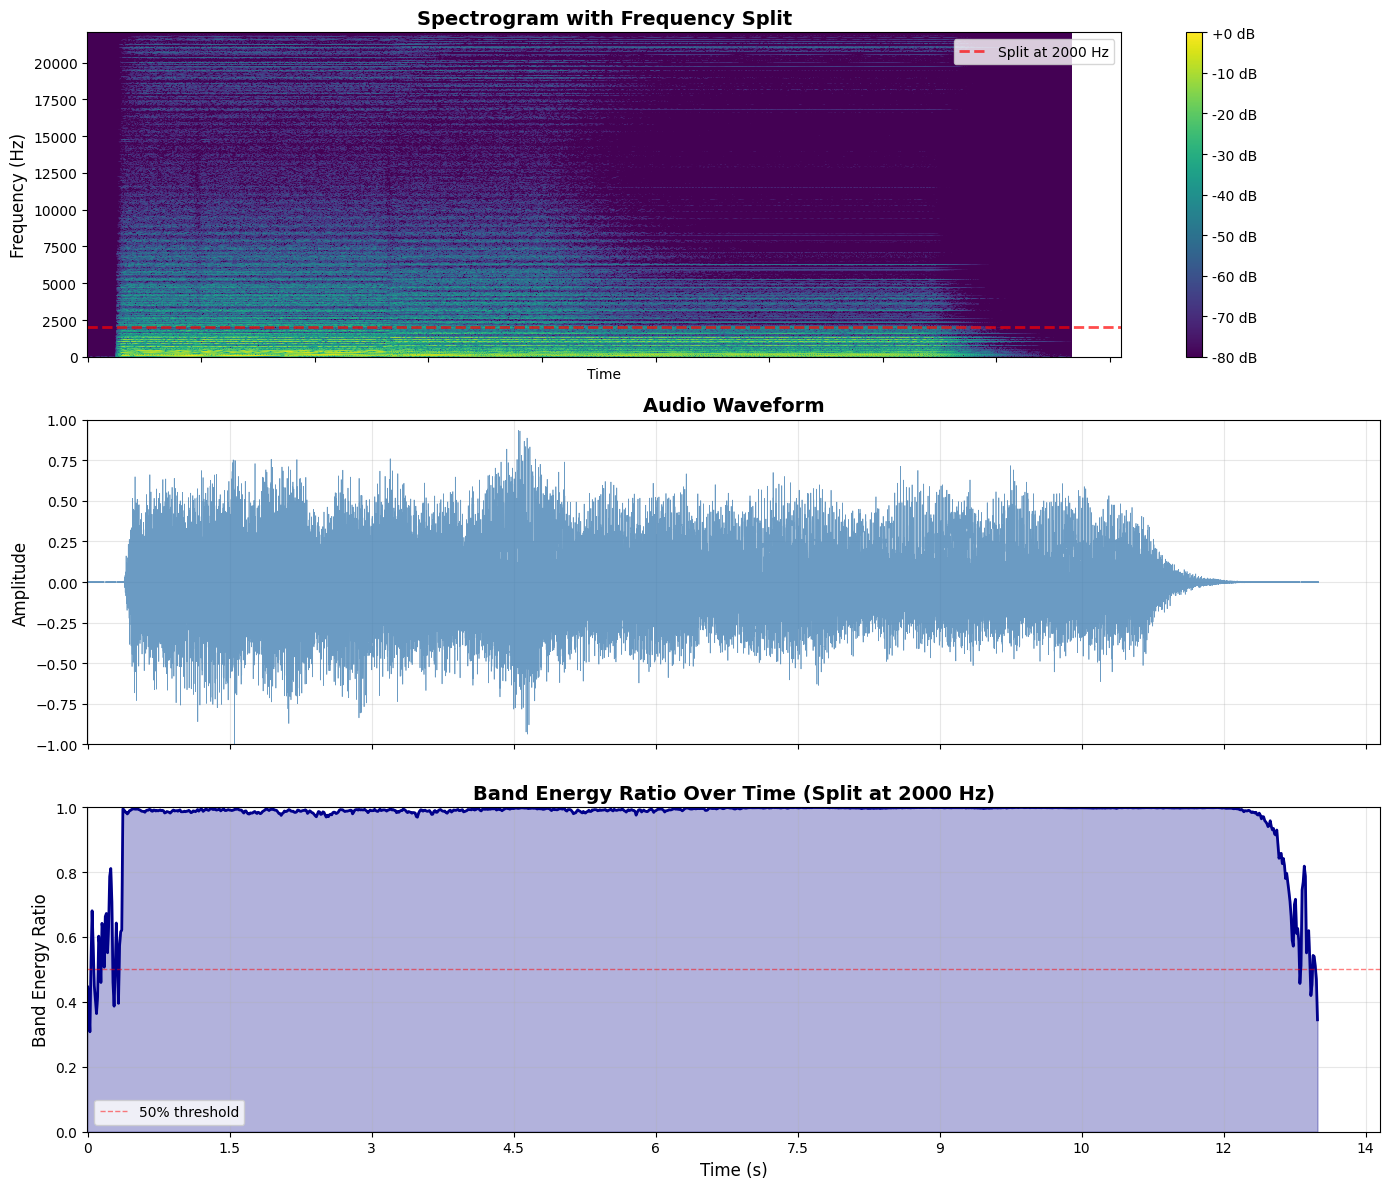


Interpretation:
- BER close to 1: Energy concentrated in LOW frequencies (< 2000 Hz)
- BER close to 0: Energy concentrated in HIGH frequencies (> 2000 Hz)
- BER around 0.5: Balanced energy distribution

The spectrogram shows frequency content, waveform shows amplitude, and BER quantifies the frequency balance.


In [26]:
# Create a comprehensive stacked visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Spectrogram (top)
D = librosa.amplitude_to_db(np.abs(librosa.stft(scale, hop_length=HOP_SIZE)), ref=np.max)
img = librosa.display.specshow(D, sr=sr, hop_length=HOP_SIZE, x_axis='time', y_axis='hz', 
                                ax=axes[0], cmap='viridis')
axes[0].axhline(y=SPLIT_FREQUENCY, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label=f'Split at {SPLIT_FREQUENCY} Hz')
axes[0].set_ylabel('Frequency (Hz)', fontsize=12)
axes[0].set_title('Spectrogram with Frequency Split', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
fig.colorbar(img, ax=axes[0], format='%+2.0f dB')

# 2. Waveform (middle)
time_samples = np.arange(len(scale)) / sr
axes[1].plot(time_samples, scale, linewidth=0.5, color='steelblue', alpha=0.8)
axes[1].set_ylabel('Amplitude', fontsize=12)
axes[1].set_title('Audio Waveform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-1, 1])

# 3. Band Energy Ratio (bottom)
frames = range(len(ber_scale))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
axes[2].plot(time_frames, ber_scale, linewidth=2, color='darkblue')
axes[2].fill_between(time_frames, ber_scale, alpha=0.3, color='darkblue')
axes[2].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, 
                label='50% threshold')
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('Band Energy Ratio', fontsize=12)
axes[2].set_title(f'Band Energy Ratio Over Time (Split at {SPLIT_FREQUENCY} Hz)', 
                  fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"- BER close to 1: Energy concentrated in LOW frequencies (< {SPLIT_FREQUENCY} Hz)")
print(f"- BER close to 0: Energy concentrated in HIGH frequencies (> {SPLIT_FREQUENCY} Hz)")
print(f"- BER around 0.5: Balanced energy distribution")
print("\nThe spectrogram shows frequency content, waveform shows amplitude, and BER quantifies the frequency balance.")

## 5. Comparing BER Across Different Audio Files

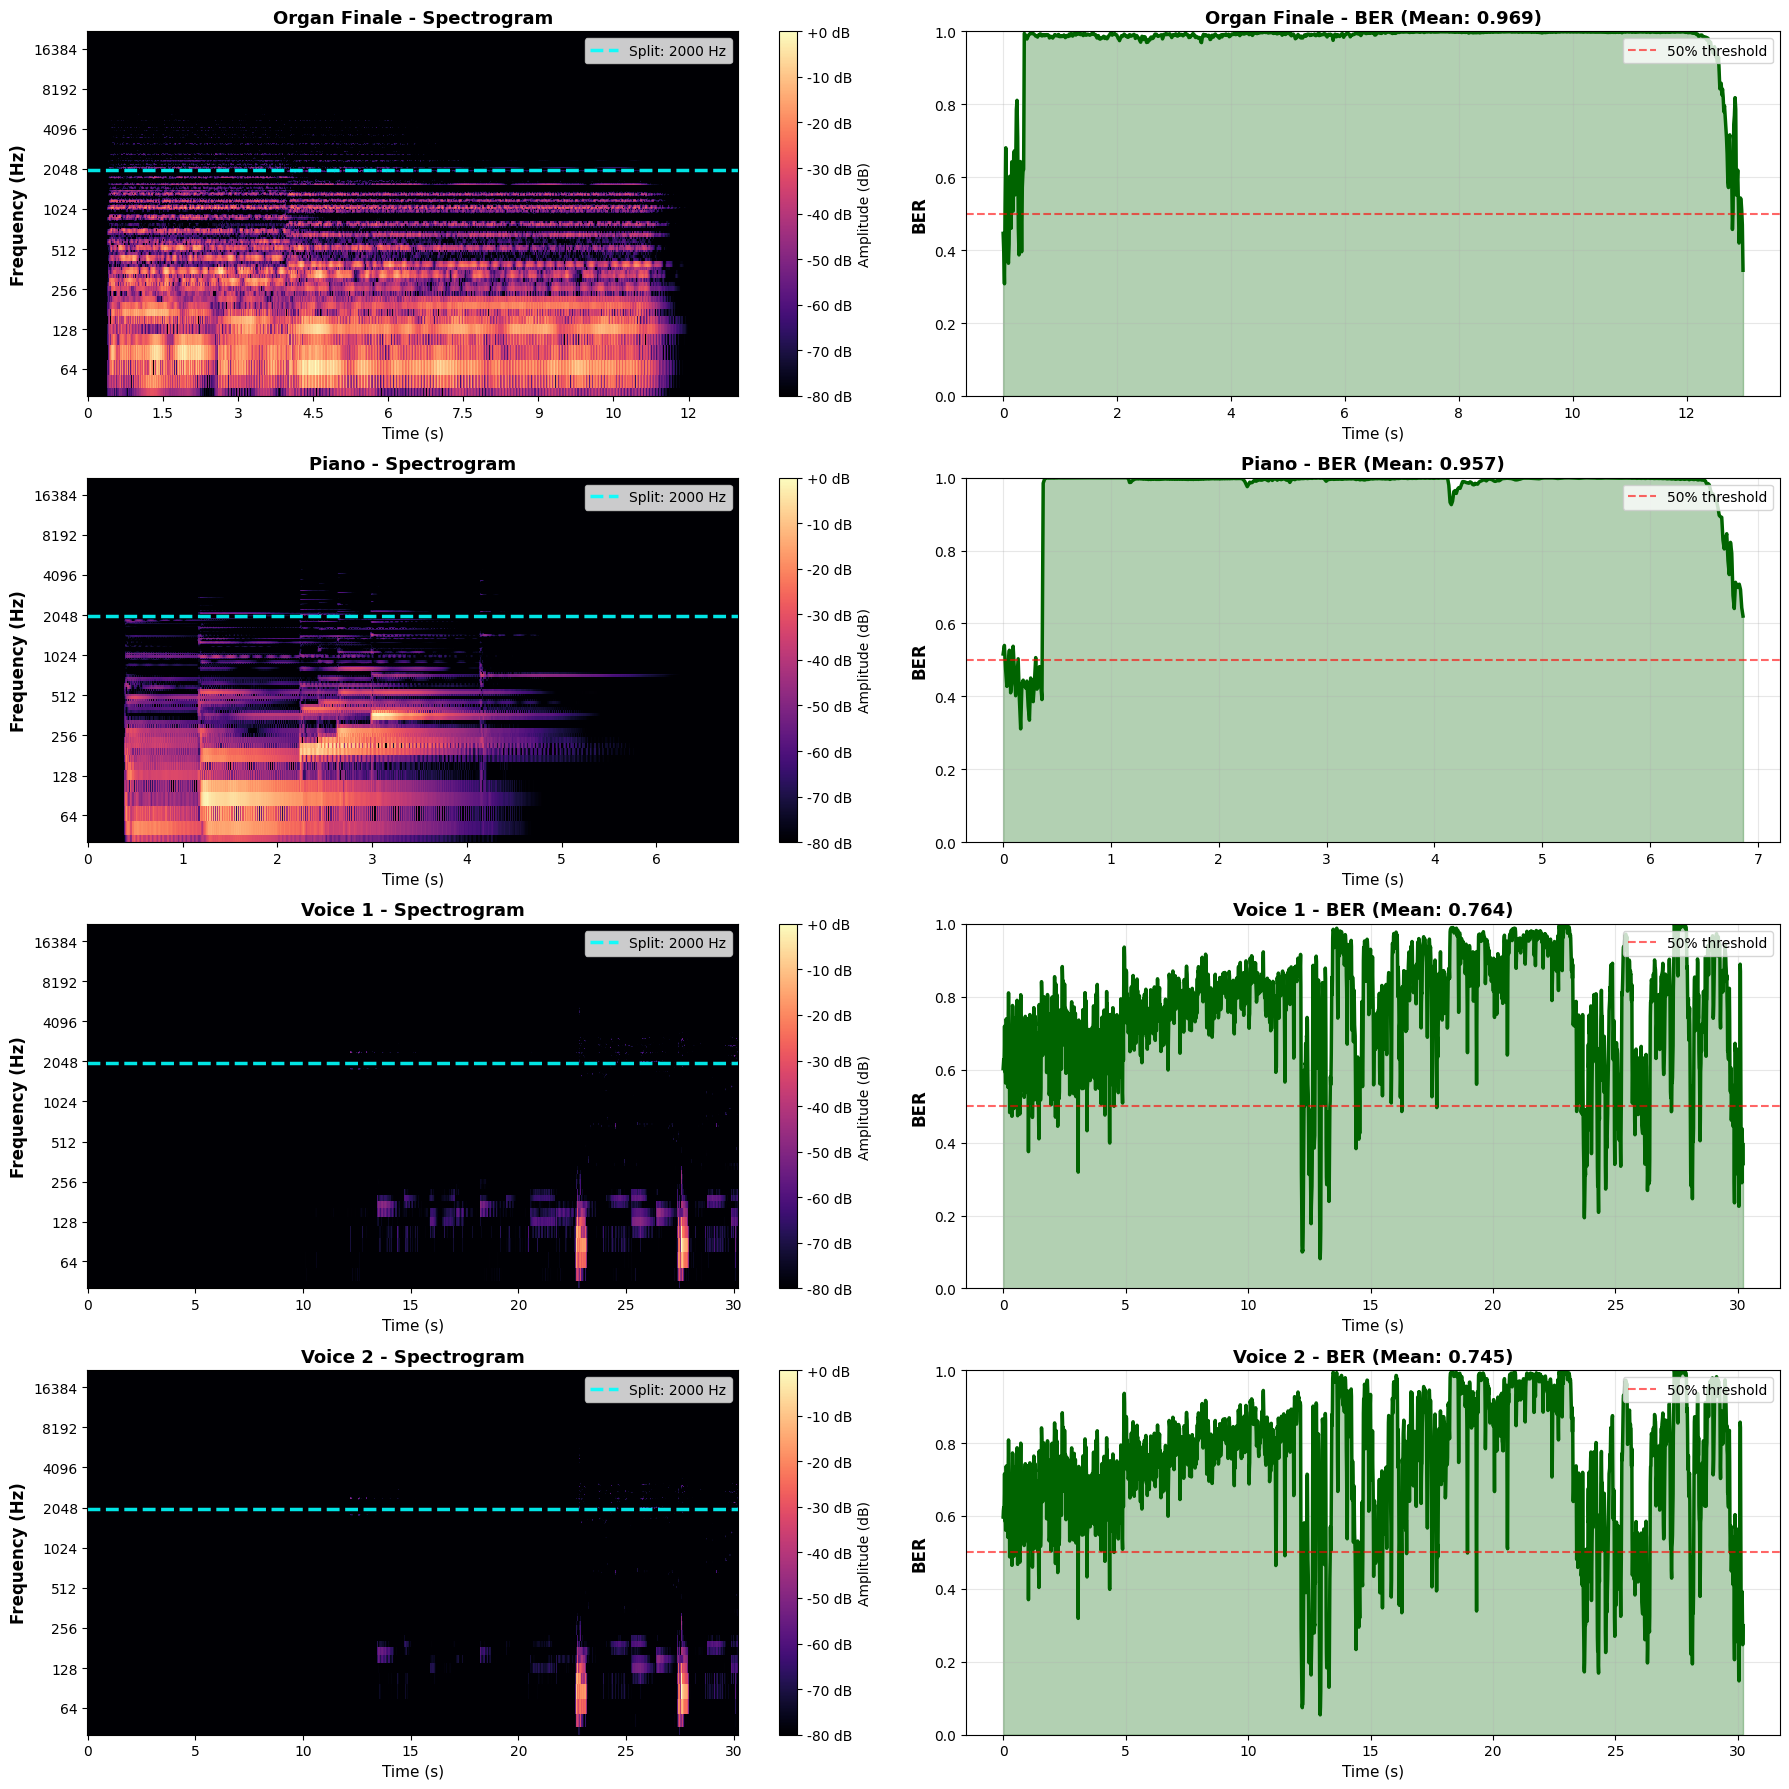

In [29]:
# Calculate BER for all audio files with enhanced side-by-side spectrogram
audio_samples = [
    (scale, 'Organ Finale'),
    (piano, 'Piano'),
    (voice1, 'Voice 1'),
    (voice2, 'Voice 2')
]

fig, axes = plt.subplots(4, 2, figsize=(18, 18))

for idx, (audio, name) in enumerate(audio_samples):
    # Compute spectrogram
    S = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    Y = np.abs(S) ** 2
    
    # Left column: Enhanced Spectrogram
    D = librosa.amplitude_to_db(Y, ref=np.max)
    
    # Use perceptual scaling and better dynamic range
    img = librosa.display.specshow(D, sr=sr, hop_length=HOP_SIZE, 
                                    x_axis='time', y_axis='log',  # Log scale for better visibility
                                    ax=axes[idx, 0], cmap='magma',  # Better colormap
                                    vmin=-80, vmax=0)  # Enhanced dynamic range
    
    axes[idx, 0].axhline(y=SPLIT_FREQUENCY, color='cyan', linestyle='--', 
                         linewidth=2.5, alpha=0.9, label=f'Split: {SPLIT_FREQUENCY} Hz')
    axes[idx, 0].set_ylabel('Frequency (Hz)', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)', fontsize=11)
    axes[idx, 0].set_title(f'{name} - Spectrogram', fontsize=13, fontweight='bold')
    axes[idx, 0].legend(loc='upper right', fontsize=10)
    axes[idx, 0].set_ylim([20, sr/2])  # Focus on audible range
    cbar = fig.colorbar(img, ax=axes[idx, 0], format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)', fontsize=10)
    
    # Right column: BER
    ber = band_energy_ratio(Y, split_freq_bin)
    frames = range(len(ber))
    time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
    
    axes[idx, 1].plot(time_frames, ber, linewidth=2.5, color='darkgreen')
    axes[idx, 1].fill_between(time_frames, ber, alpha=0.3, color='darkgreen')
    axes[idx, 1].set_xlabel('Time (s)', fontsize=11)
    axes[idx, 1].set_ylabel('BER', fontsize=12, fontweight='bold')
    axes[idx, 1].set_title(f'{name} - BER (Mean: {ber.mean():.3f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].set_ylim([0, 1])
    axes[idx, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, 
                         alpha=0.6, label='50% threshold')
    axes[idx, 1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [30]:
# Add this after your existing plot to see the energy distribution more clearly
for idx, (audio, name) in enumerate(audio_samples):
    S = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    Y = np.abs(S) ** 2
    
    # Calculate energy in each band over time
    power_low = np.sum(Y[:split_freq_bin, :], axis=0)
    power_high = np.sum(Y[split_freq_bin:, :], axis=0)
    
    print(f"\n{name}:")
    print(f"  Low band energy range: {power_low.min():.2e} to {power_low.max():.2e}")
    print(f"  High band energy range: {power_high.min():.2e} to {power_high.max():.2e}")
    print(f"  Ratio of max/min low energy: {power_low.max()/power_low.min():.2f}x")


Organ Finale:
  Low band energy range: 4.79e-03 to 9.96e+04
  High band energy range: 5.96e-03 to 1.26e+03
  Ratio of max/min low energy: 20784887.56x

Piano:
  Low band energy range: 3.12e-02 to 1.29e+05
  High band energy range: 2.92e-02 to 1.24e+03
  Ratio of max/min low energy: 4139672.04x

Voice 1:
  Low band energy range: 7.58e-03 to 3.01e+05
  High band energy range: 6.13e-03 to 2.88e+03
  Ratio of max/min low energy: 39676315.14x

Voice 2:
  Low band energy range: 8.10e-03 to 3.06e+05
  High band energy range: 6.79e-03 to 3.01e+03
  Ratio of max/min low energy: 37800568.18x


**Question? here - i see most of the frequencies are concentrated below split line,  but why is BER varying bw 0.2 and 1 frequently?**

Great observation! The BER is varying because it's measuring the ratio of energy, not just the presence of frequencies. Here's why:

Key reasons for BER variation:

Temporal dynamics - Even though most frequencies are below the split line, the relative energy between low and high bands changes moment-to-moment as the person speaks

Speech characteristics:

Vowels (a, e, i, o, u) → More low-frequency energy → BER closer to 1
Consonants (s, t, k, f, sh) → More high-frequency energy → BER drops toward 0
Silence/pauses → Can cause unstable ratios
Harmonics and formants - Voice has harmonic structure that shifts energy distribution even within the visible frequency range

## 6. Spectral Centroid



### Theory



The **Spectral Centroid** is the "center of mass" or "center of gravity" of the spectrum. It indicates where the "center" of the frequencies is located and is widely used to quantify the **brightness** of a sound.



### Mathematical Definition



$$SC_t = \frac{\sum_{n=1}^{N} f(n) \cdot m_t(n)}{\sum_{n=1}^{N} m_t(n)}$$



Where:
- $SC_t$ = Spectral Centroid at frame $t$
- $f(n)$ = Frequency value at bin $n$
- $m_t(n)$ = Magnitude of the frequency at bin $n$ for frame $t$
- $N$ = Total number of frequency bins



This is essentially a **weighted mean** of the frequencies, where the weights are the magnitudes.



### Perception



- **High Centroid**: Brighter sound (more high-frequency content)
  - Examples: Trumpet, cymbal, "s" sound in speech
- **Low Centroid**: Darker sound (more low-frequency content)
  - Examples: Cello, bass drum, "u" sound in speech



### Applications



1. **Music Genre Classification**: Distinguishing bright genres (Pop, Electronic) from dark genres (Blues, Jazz)
2. **Instrument Recognition**: Identifying bright vs dark instruments
3. **Speech Analysis**: Analyzing phoneme characteristics
4. **Audio Segmentation**: Detecting changes in timbre

## 7. Computing Spectral Centroid from Scratch

In [8]:
def spectral_centroid(spectrogram, sr, n_fft):
    """
    Calculate Spectral Centroid for each frame.
    
    Parameters:
    - spectrogram: Magnitude spectrogram (frequency bins x time frames)
    - sr: Sample rate
    - n_fft: FFT size
    
    Returns:
    - Spectral centroid values (in Hz) for each time frame
    """
    # Get frequency values for each bin
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # Calculate weighted mean for each frame
    # Numerator: sum of (frequency * magnitude)
    # Denominator: sum of magnitudes
    centroid = np.sum(freqs[:, np.newaxis] * spectrogram, axis=0) / (np.sum(spectrogram, axis=0) + 1e-10)
    
    return centroid

# Calculate spectral centroid for scale audio
S_scale_mag = np.abs(S_scale)
centroid_scale = spectral_centroid(S_scale_mag, sr, FRAME_SIZE)

print(f"Spectral Centroid shape: {centroid_scale.shape}")
print(f"Centroid range: [{centroid_scale.min():.2f}, {centroid_scale.max():.2f}] Hz")
print(f"Mean Centroid: {centroid_scale.mean():.2f} Hz")

Spectral Centroid shape: (1120,)
Centroid range: [699.63, 12522.30] Hz
Mean Centroid: 1983.56 Hz


## 8. Visualizing Spectral Centroid

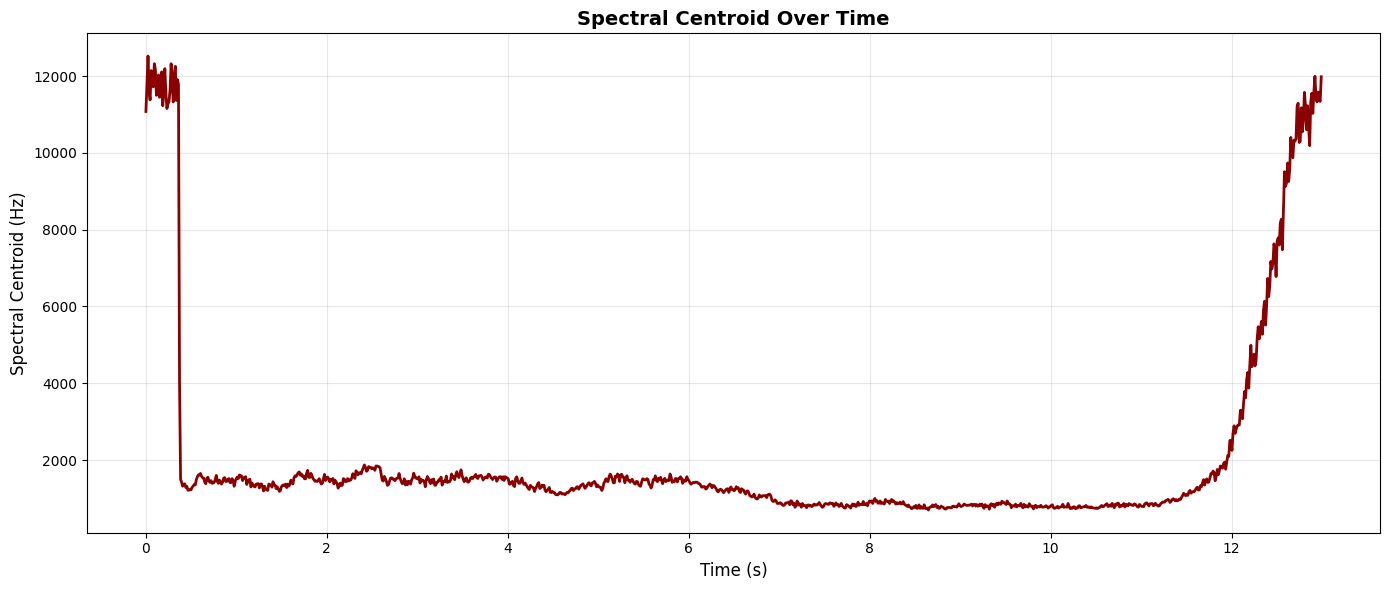

Interpretation:
- Higher values: Brighter, more high-frequency content
- Lower values: Darker, more low-frequency content
- Changes over time indicate timbral variations


In [9]:
# Visualize spectral centroid over time
frames = range(len(centroid_scale))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

plt.figure(figsize=(14, 6))
plt.plot(time_frames, centroid_scale, linewidth=2, color='darkred')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Spectral Centroid (Hz)', fontsize=12)
plt.title('Spectral Centroid Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Higher values: Brighter, more high-frequency content")
print("- Lower values: Darker, more low-frequency content")
print("- Changes over time indicate timbral variations")

## 9. Spectral Centroid with Spectrogram Overlay

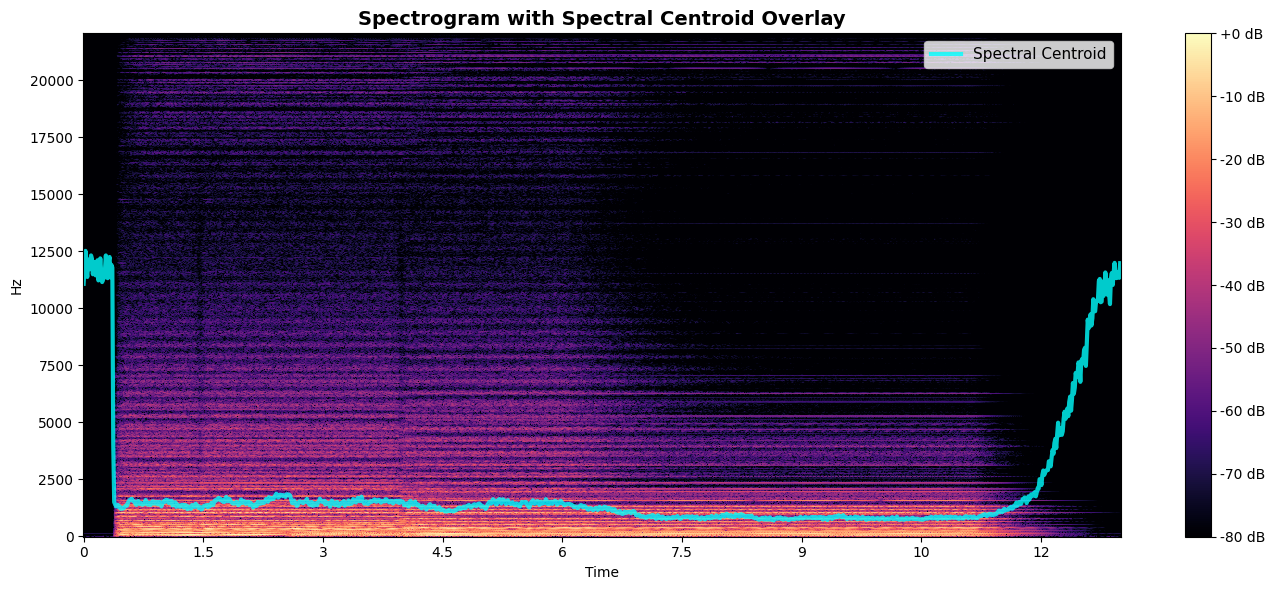

Observation:
The cyan line shows the 'center of mass' of the spectrum at each time frame.
It tracks where most of the spectral energy is concentrated.


In [10]:
# Create a visualization with spectrogram and centroid overlay
Y_scale_db = librosa.power_to_db(Y_scale, ref=np.max)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot spectrogram
img = librosa.display.specshow(Y_scale_db, sr=sr, hop_length=HOP_SIZE,
                                x_axis='time', y_axis='hz', cmap='magma', ax=ax)

# Overlay spectral centroid
frames = range(len(centroid_scale))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
ax.plot(time_frames, centroid_scale, color='cyan', linewidth=3, 
        label='Spectral Centroid', alpha=0.8)

ax.set_title('Spectrogram with Spectral Centroid Overlay', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
plt.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
plt.show()

print("Observation:")
print("The cyan line shows the 'center of mass' of the spectrum at each time frame.")
print("It tracks where most of the spectral energy is concentrated.")

## 10. Comparing Spectral Centroid Across Different Audio

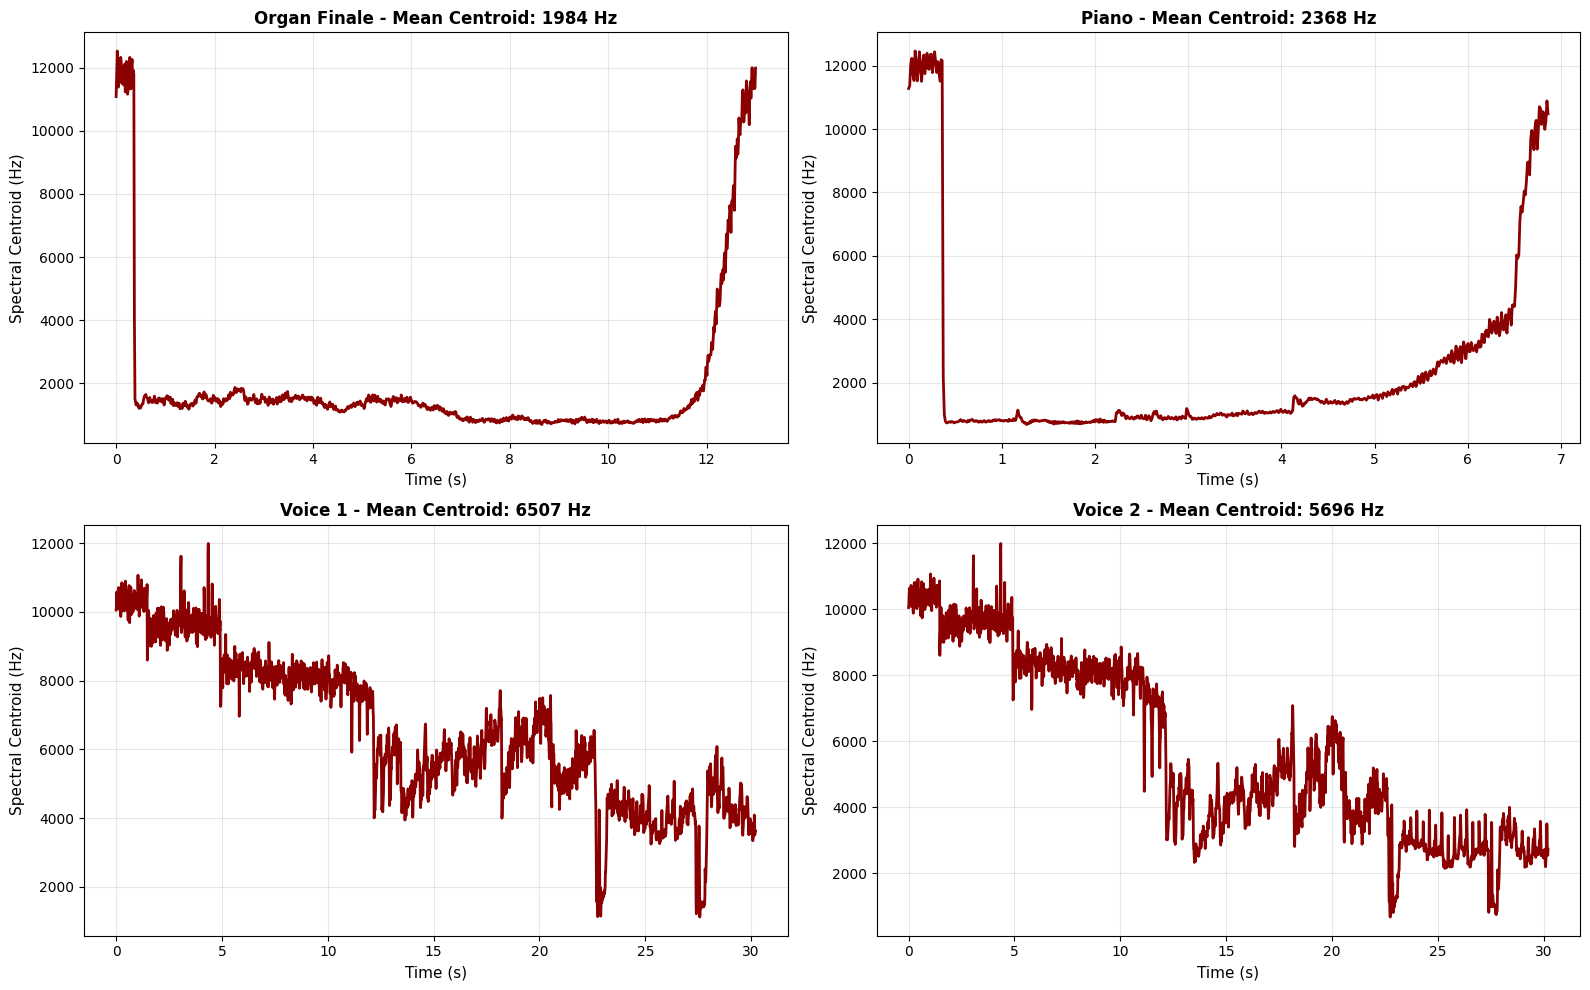

Observations:
- Different audio sources have different average centroid values
- Higher centroid = brighter sound
- Temporal variations show timbral changes


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (audio, name) in enumerate(audio_samples):
    # Compute spectrogram
    S = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    S_mag = np.abs(S)
    
    # Calculate spectral centroid
    centroid = spectral_centroid(S_mag, sr, FRAME_SIZE)
    
    # Plot
    frames = range(len(centroid))
    time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
    
    axes[idx].plot(time_frames, centroid, linewidth=2, color='darkred')
    axes[idx].set_xlabel('Time (s)', fontsize=11)
    axes[idx].set_ylabel('Spectral Centroid (Hz)', fontsize=11)
    axes[idx].set_title(f'{name} - Mean Centroid: {centroid.mean():.0f} Hz', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Different audio sources have different average centroid values")
print("- Higher centroid = brighter sound")
print("- Temporal variations show timbral changes")

## 11. Spectral Bandwidth (Spectral Spread)



### Theory



**Spectral Bandwidth** (also called **Spectral Spread**) describes the width of the spectrum or how spread out the energy is around the Spectral Centroid. It acts as a measure of the **variance** of the frequencies.



### Mathematical Definition



$$SB_t = \sqrt{\frac{\sum_{n=1}^{N} (f(n) - SC_t)^2 \cdot m_t(n)}{\sum_{n=1}^{N} m_t(n)}}$$



Where:
- $SB_t$ = Spectral Bandwidth at frame $t$
- $SC_t$ = Spectral Centroid (calculated previously)
- $f(n)$ = Frequency value at bin $n$
- $m_t(n)$ = Magnitude at bin $n$ for frame $t$
- $(f(n) - SC_t)^2$ = Squared distance from the centroid



This is essentially the **weighted standard deviation** of the frequencies.



### Perception



- **High Bandwidth**: Noisy, broad sounds
  - Examples: White noise, applause, cymbals, "sh" sound
  - Energy is spread across a wide range of frequencies
  
- **Low Bandwidth**: Tonal, pure sounds
  - Examples: Pure sine wave, single piano note, flute
  - Energy is concentrated near the centroid



### Applications



1. **Sound Classification**: Distinguishing tonal vs noisy sounds
2. **Music Analysis**: Identifying harmonic vs percussive content
3. **Speech Analysis**: Analyzing phoneme characteristics
4. **Audio Quality Assessment**: Detecting distortion or noise

## 12. Computing Spectral Bandwidth from Scratch

In [12]:
def spectral_bandwidth(spectrogram, centroid, sr, n_fft):
    """
    Calculate Spectral Bandwidth for each frame.
    
    Parameters:
    - spectrogram: Magnitude spectrogram (frequency bins x time frames)
    - centroid: Spectral centroid values for each frame
    - sr: Sample rate
    - n_fft: FFT size
    
    Returns:
    - Spectral bandwidth values (in Hz) for each time frame
    """
    # Get frequency values for each bin
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # Calculate weighted variance for each frame
    # (frequency - centroid)^2 * magnitude
    deviation = (freqs[:, np.newaxis] - centroid[np.newaxis, :]) ** 2
    bandwidth = np.sqrt(np.sum(deviation * spectrogram, axis=0) / (np.sum(spectrogram, axis=0) + 1e-10))
    
    return bandwidth

# Calculate spectral bandwidth for scale audio
bandwidth_scale = spectral_bandwidth(S_scale_mag, centroid_scale, sr, FRAME_SIZE)

print(f"Spectral Bandwidth shape: {bandwidth_scale.shape}")
print(f"Bandwidth range: [{bandwidth_scale.min():.2f}, {bandwidth_scale.max():.2f}] Hz")
print(f"Mean Bandwidth: {bandwidth_scale.mean():.2f} Hz")

Spectral Bandwidth shape: (1120,)
Bandwidth range: [1694.53, 7779.58] Hz
Mean Bandwidth: 2988.42 Hz


## 13. Visualizing Spectral Bandwidth

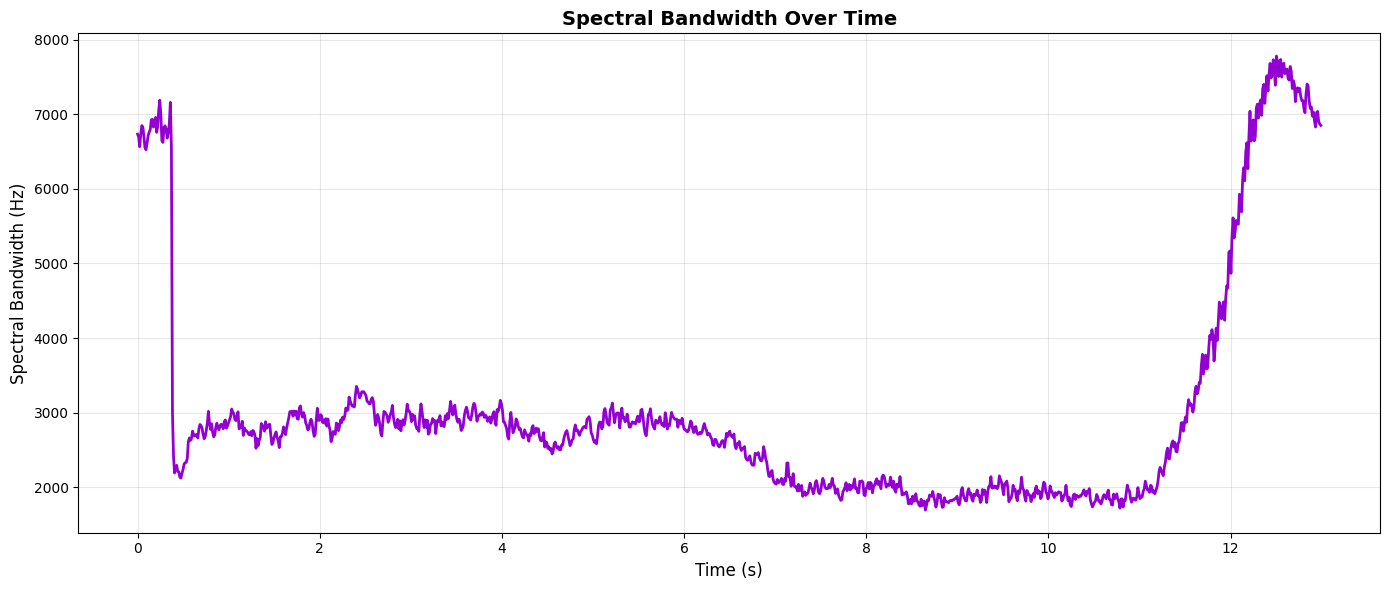

Interpretation:
- Higher values: Noisy, broad spectrum (energy spread across many frequencies)
- Lower values: Tonal, narrow spectrum (energy concentrated near centroid)
- Indicates the 'purity' or 'noisiness' of the sound


In [13]:
# Visualize spectral bandwidth over time
frames = range(len(bandwidth_scale))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

plt.figure(figsize=(14, 6))
plt.plot(time_frames, bandwidth_scale, linewidth=2, color='darkviolet')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Spectral Bandwidth (Hz)', fontsize=12)
plt.title('Spectral Bandwidth Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Higher values: Noisy, broad spectrum (energy spread across many frequencies)")
print("- Lower values: Tonal, narrow spectrum (energy concentrated near centroid)")
print("- Indicates the 'purity' or 'noisiness' of the sound")

## 14. Comparing Spectral Bandwidth Across Different Audio

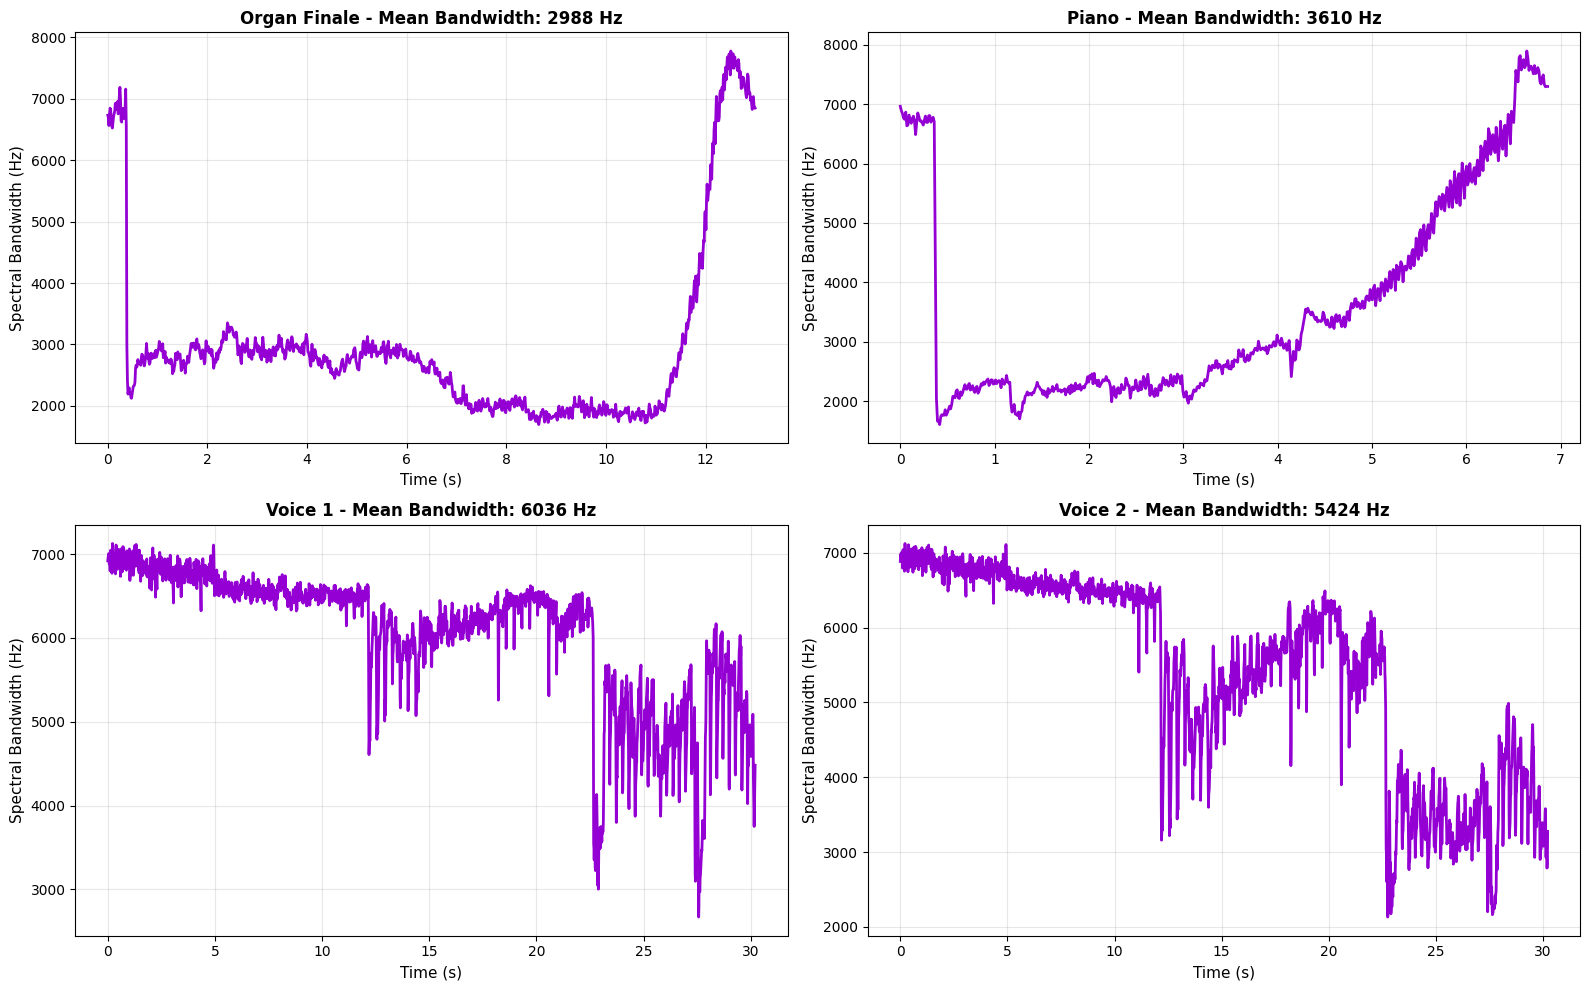

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (audio, name) in enumerate(audio_samples):
    # Compute spectrogram
    S = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    S_mag = np.abs(S)
    
    # Calculate spectral centroid and bandwidth
    centroid = spectral_centroid(S_mag, sr, FRAME_SIZE)
    bandwidth = spectral_bandwidth(S_mag, centroid, sr, FRAME_SIZE)
    
    # Plot
    frames = range(len(bandwidth))
    time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
    
    axes[idx].plot(time_frames, bandwidth, linewidth=2, color='darkviolet')
    axes[idx].set_xlabel('Time (s)', fontsize=11)
    axes[idx].set_ylabel('Spectral Bandwidth (Hz)', fontsize=11)
    axes[idx].set_title(f'{name} - Mean Bandwidth: {bandwidth.mean():.0f} Hz', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Combined Visualization: All Three Features

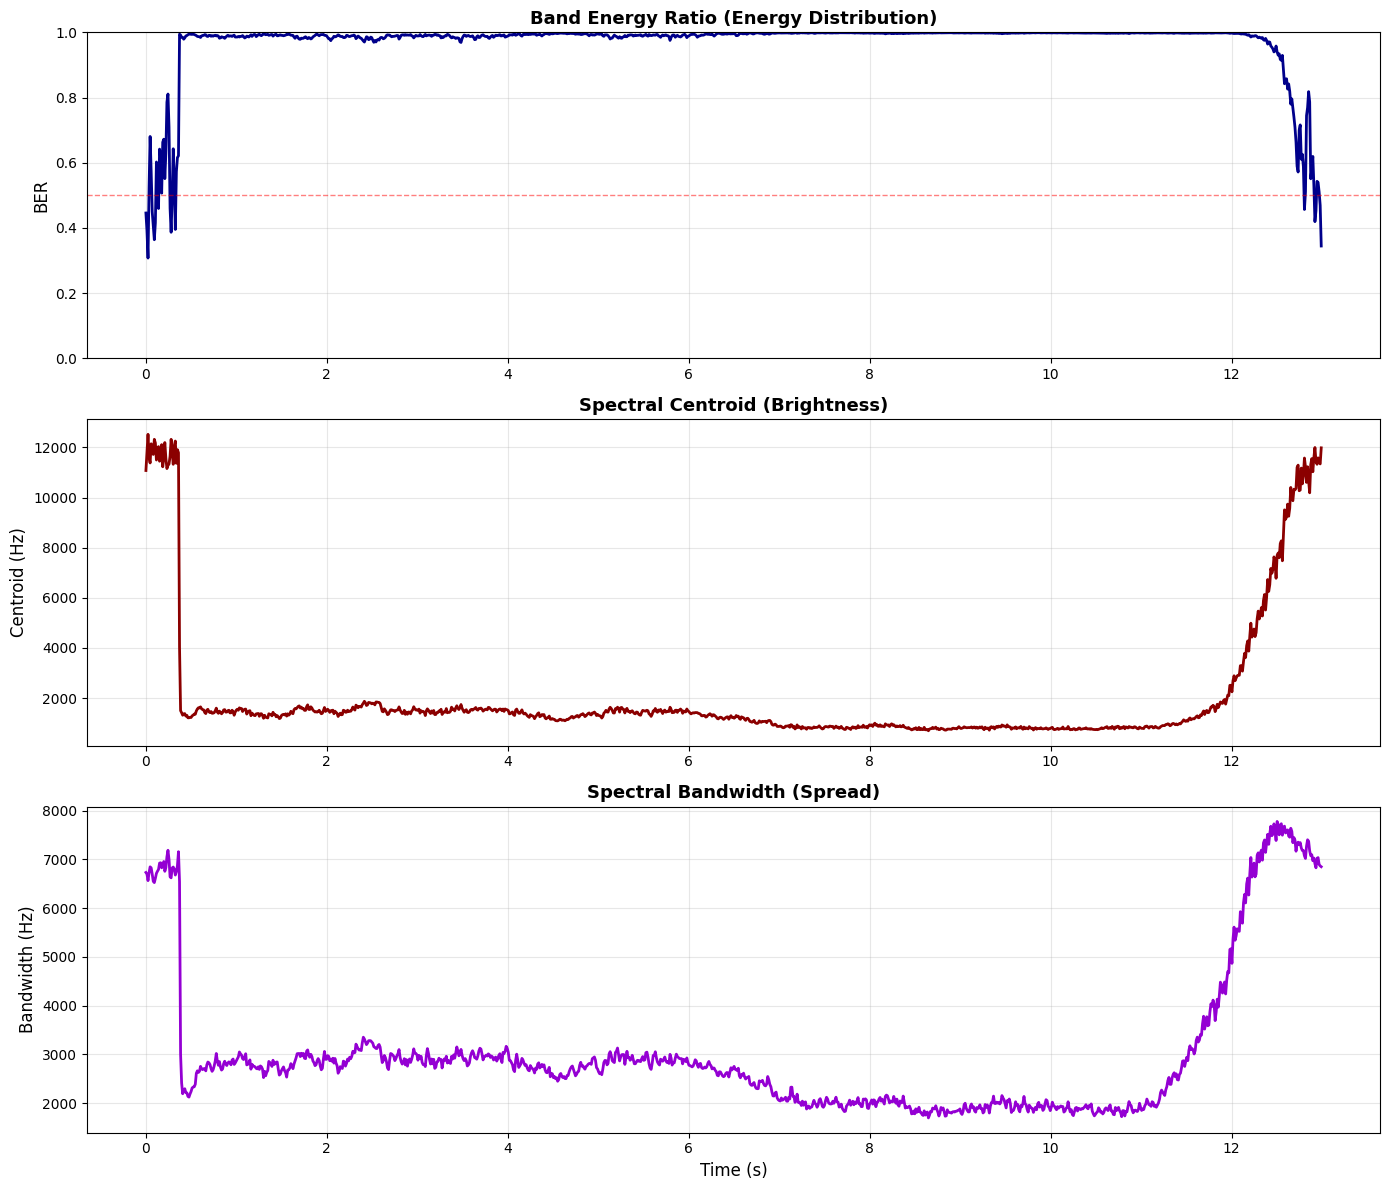

Combined Interpretation:
- BER: Shows energy distribution (low vs high frequencies)
- Centroid: Shows brightness (where the spectral center is)
- Bandwidth: Shows spread (how concentrated or dispersed the energy is)


In [15]:
# Calculate all features for scale audio
ber_scale = band_energy_ratio(Y_scale, split_freq_bin)
centroid_scale = spectral_centroid(S_scale_mag, sr, FRAME_SIZE)
bandwidth_scale = spectral_bandwidth(S_scale_mag, centroid_scale, sr, FRAME_SIZE)

# Create combined plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

frames = range(len(ber_scale))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

# Plot 1: Band Energy Ratio
axes[0].plot(time_frames, ber_scale, linewidth=2, color='darkblue')
axes[0].set_ylabel('BER', fontsize=12)
axes[0].set_title('Band Energy Ratio (Energy Distribution)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Spectral Centroid
axes[1].plot(time_frames, centroid_scale, linewidth=2, color='darkred')
axes[1].set_ylabel('Centroid (Hz)', fontsize=12)
axes[1].set_title('Spectral Centroid (Brightness)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Spectral Bandwidth
axes[2].plot(time_frames, bandwidth_scale, linewidth=2, color='darkviolet')
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('Bandwidth (Hz)', fontsize=12)
axes[2].set_title('Spectral Bandwidth (Spread)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Combined Interpretation:")
print("- BER: Shows energy distribution (low vs high frequencies)")
print("- Centroid: Shows brightness (where the spectral center is)")
print("- Bandwidth: Shows spread (how concentrated or dispersed the energy is)")

## 16. Practical Implementation with Librosa

In [16]:
# Extract features using librosa's built-in functions
ber_librosa = band_energy_ratio(Y_scale, split_freq_bin)  # Custom function
centroid_librosa = librosa.feature.spectral_centroid(y=scale, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
bandwidth_librosa = librosa.feature.spectral_bandwidth(y=scale, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]

print("Librosa Implementation:")
print(f"Spectral Centroid shape: {centroid_librosa.shape}")
print(f"Spectral Bandwidth shape: {bandwidth_librosa.shape}")
print(f"\nMean values:")
print(f"- Centroid: {centroid_librosa.mean():.2f} Hz")
print(f"- Bandwidth: {bandwidth_librosa.mean():.2f} Hz")

Librosa Implementation:
Spectral Centroid shape: (1120,)
Spectral Bandwidth shape: (1120,)

Mean values:
- Centroid: 1983.56 Hz
- Bandwidth: 2988.42 Hz


## 17. Feature Comparison Table

In [17]:
# Create a comparison table for all audio samples
feature_data = []

for audio, name in audio_samples:
    # Compute spectrogram
    S = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    Y = np.abs(S) ** 2
    S_mag = np.abs(S)
    
    # Calculate features
    ber = band_energy_ratio(Y, split_freq_bin)
    centroid = spectral_centroid(S_mag, sr, FRAME_SIZE)
    bandwidth = spectral_bandwidth(S_mag, centroid, sr, FRAME_SIZE)
    
    feature_data.append({
        'Audio': name,
        'Mean BER': f"{ber.mean():.3f}",
        'Mean Centroid (Hz)': f"{centroid.mean():.0f}",
        'Mean Bandwidth (Hz)': f"{bandwidth.mean():.0f}",
        'Interpretation': 'Bright' if centroid.mean() > 2000 else 'Dark'
    })

df_features = pd.DataFrame(feature_data)
print("="*80)
print("FREQUENCY-DOMAIN FEATURES SUMMARY")
print("="*80)
print(df_features.to_string(index=False))
print("="*80)

FREQUENCY-DOMAIN FEATURES SUMMARY
       Audio Mean BER Mean Centroid (Hz) Mean Bandwidth (Hz) Interpretation
Organ Finale    0.969               1984                2988           Dark
       Piano    0.957               2368                3610         Bright
     Voice 1    0.764               6507                6036         Bright
     Voice 2    0.745               5696                5424         Bright


## 18. Summary



### Key Takeaways



**1. Band Energy Ratio (BER)**
- Measures energy distribution across frequency bands
- High BER = low-frequency energy (bass-heavy)
- Low BER = high-frequency energy (treble-heavy)
- Applications: Genre classification, speech analysis

**2. Spectral Centroid**
- "Center of mass" of the spectrum
- Indicates brightness of sound
- High centroid = bright sound (high frequencies)
- Low centroid = dark sound (low frequencies)
- Applications: Timbre analysis, instrument recognition

**3. Spectral Bandwidth**
- Spread of frequencies around the centroid
- High bandwidth = noisy, broad spectrum
- Low bandwidth = tonal, pure sound
- Applications: Sound classification, quality assessment



### Why These Features Matter



These three features provide complementary information about audio:
- **BER**: Energy distribution (where is the energy?)
- **Centroid**: Brightness (what is the spectral center?)
- **Bandwidth**: Spread (how concentrated is the energy?)

Together, they form a robust representation of the **timbre** and **spectral characteristics** of audio signals, making them essential for:
- Music Information Retrieval
- Speech Processing
- Audio Classification
- Sound Quality Analysis



### Next Steps



1. Experiment with different audio samples
2. Combine features for classification tasks
3. Explore sequence modeling with RNNs/LSTMs
4. Build end-to-end audio ML applications



**Congratulations!** You now have a solid understanding of frequency-domain audio features and are ready to tackle advanced audio machine learning tasks!